In [1]:
import os
import sys
import pandas as pd
import yaml 
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from matplotlib import colors as mcolors
from matplotlib import patches as mpatches
import statsmodels.api as sm
import numpy as np
from itertools import product
import subprocess
import networkx as nx

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor, XGBClassifier

import shap

with open("../../config.yaml.local", "r") as f:
    LOCAL_CONFIG = yaml.safe_load(f)
with open("../../config.yaml", "r") as f:
    CONFIG = yaml.safe_load(f)
sys.path.append("../python")

import globals
import data_tools as dt
import utils
import emb

LOCAL_PATH = LOCAL_CONFIG["LOCAL_PATH"]
RAW_DATA_PATH = LOCAL_CONFIG["RAW_DATA_PATH"]
DATA_PATH = LOCAL_CONFIG["DATA_PATH"]
R_PATH = LOCAL_CONFIG["R_PATH"]

RUN_R_SCRIPTS = False
OVERWRITE = False


/Users/ekung/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = dt.get_post_quality_analysis_data()

df = df.loc[df['title'] != 'deleted by author'].reset_index(drop=True)

/Users/ekung/projects/sn-research/src/notebooks/../python/data_tools.py:89: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.dt.to_period('W-SAT').dt.start_time
/Users/ekung/projects/sn-research/src/notebooks/../python/data_tools.py:89: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.dt.to_period('W-SAT').dt.start_time


In [3]:
subs = df['subName'].unique().tolist()
sub_embeddings = {}
for sub in subs:
    embedding = np.array(emb.get_embedding_robust(sub))
    embedding = embedding / np.linalg.norm(embedding)
    sub_embeddings[sub] = embedding

In [4]:
title_embeddings = []
text_embeddings = []

for idx, row in df.iterrows():
    title_emb = np.array(emb.get_embedding_robust(row['title']))
    title_emb = title_emb / np.linalg.norm(title_emb)
    title_embeddings.append(title_emb)
    
    text_emb = np.array(emb.get_embedding_robust(row['text']))
    text_emb = text_emb / np.linalg.norm(text_emb)
    text_embeddings.append(text_emb)

title_embeddings = np.array(title_embeddings)
text_embeddings = np.array(text_embeddings)

In [5]:
#for idx, row in df.iterrows():
#    title = row['title']
#    text = row['text']
#    sub = row['subName']
#    
#    title_embedding = np.array(emb.get_embedding_robust(title))
#    title_embedding = title_embedding / np.linalg.norm(title_embedding)
#    
#    text_embedding = np.array(emb.get_embedding_robust(text))
#    text_embedding = text_embedding / np.linalg.norm(text_embedding)#
#
#    title_cos_dist = 1 - np.dot(title_embedding, sub_embeddings[sub])
#    text_cos_dist = 1 - np.dot(text_embedding, sub_embeddings[sub])
#
#    df.at[idx, 'title_cos_dist'] = title_cos_dist
#    df.at[idx, 'text_cos_dist'] = text_cos_dist

In [6]:
emb.close_connections()

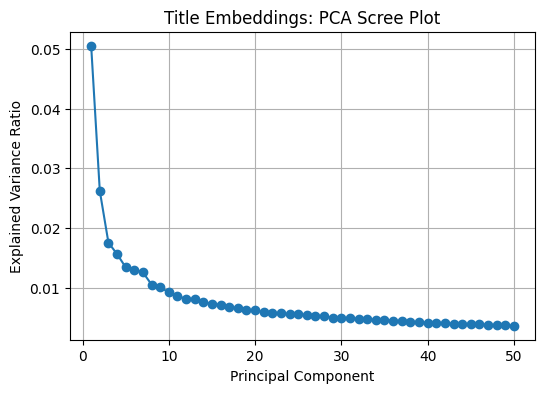

In [7]:
# scree plot for title embeddings
title_pca = PCA()
title_pca.fit(title_embeddings)
explained_variance = title_pca.explained_variance_ratio_[0:50]
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Title Embeddings: PCA Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid()
#filename = os.path.join(LOCAL_PATH, 'figures', 'fig_scree_plot.pdf')
#plt.savefig(filename, bbox_inches='tight')
plt.show()



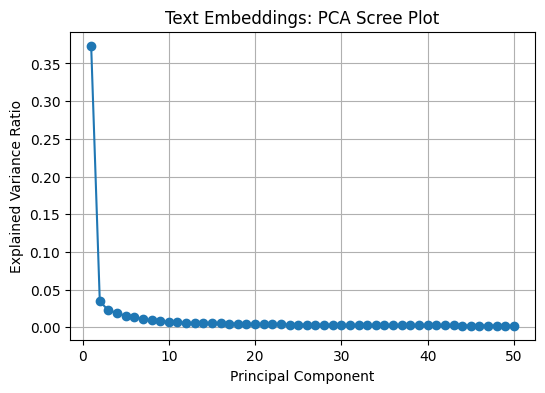

In [8]:
# scree plot for text embeddings
text_pca = PCA()
text_pca.fit(text_embeddings)
explained_variance = text_pca.explained_variance_ratio_[0:50]
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Text Embeddings: PCA Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid()
#filename = os.path.join(LOCAL_PATH, 'figures', 'fig_scree_plot.pdf')
#plt.savefig(filename, bbox_inches='tight')
plt.show()



In [9]:
TITLE_PCA_K = 20

title_pca = PCA(n_components=TITLE_PCA_K)
title_pca.fit(title_embeddings)
title_pca_embeddings = title_pca.transform(title_embeddings)

for k in range(TITLE_PCA_K):
    df[f'title_emb_{k}'] = title_pca_embeddings[:, k]

TEXT_PCA_K = 20

text_pca = PCA(n_components=TEXT_PCA_K)
text_pca.fit(text_embeddings)
text_pca_embeddings = text_pca.transform(text_embeddings)

for k in range(TEXT_PCA_K):
    df[f'text_emb_{k}'] = text_pca_embeddings[:, k]

In [10]:
title_emb_cols = [f'title_emb_{k}' for k in range(TITLE_PCA_K)]
text_emb_cols = [f'text_emb_{k}' for k in range(TEXT_PCA_K)]
feature_cols = ['num_words', 'num_img_or_links', 'is_link_post'] + title_emb_cols + text_emb_cols

df['log_sats48'] = np.log1p(df['sats48'])

X = df[feature_cols]
Y = df['log_sats48']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=21)

model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=21
)

In [11]:
model.fit(X, Y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=21, ...)

In [34]:
Y_pred = model.predict(X)

rmse = np.sqrt(mean_squared_error(Y, Y_pred))
r2 = r2_score(Y, Y_pred)

print(f"XGB Model")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")
print(f"N: {len(Y)}")

XGB Model
RMSE: 1.8998
R2: 0.3482
N: 175857


In [13]:
# OLS model for comparison

ols = LinearRegression(fit_intercept=True)
ols.fit(X, Y)
Y_pred_ols = ols.predict(X)
rmse_ols = np.sqrt(mean_squared_error(Y, Y_pred_ols))
r2_ols = r2_score(Y, Y_pred_ols)

print(f"OLS Model")
print(f"RMSE: {rmse_ols:.4f}")
print(f"R2: {r2_ols:.4f}")

OLS Model
RMSE: 2.1015
R2: 0.2025


In [14]:
feature_importance = pd.Series(
    model.feature_importances_, 
    index=model.feature_names_in_
).sort_values(ascending=False)

fi = feature_importance.rename('importance').reset_index()
fi['feature_group'] = fi['index']
fi.loc[ fi['index'].isin(title_emb_cols), 'feature_group' ] = 'title_embeddings'
fi.loc[ fi['index'].isin(text_emb_cols), 'feature_group' ] = 'text_embeddings'
fi = fi.groupby('feature_group').agg(
    importance = ('importance', 'sum')
).reset_index()

fi


,feature_group,importance
0,is_link_post,0.090506
1,num_img_or_links,0.038506
2,num_words,0.201383
3,text_embeddings,0.450209
4,title_embeddings,0.219395


In [15]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

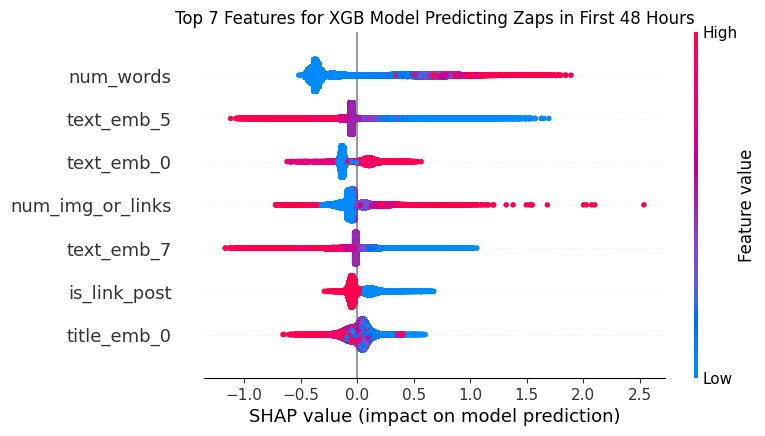

In [33]:
plt.figure(figsize=(6,4))
shap.summary_plot(shap_values, X, max_display=7, show=False)
plt.title("Top 7 Features for XGB Model Predicting Zaps in First 48 Hours")
plt.xlabel("SHAP value (impact on model prediction)")
plt.show()

In [17]:
print("Examples with high values of text_emb_5")
print("")

mydf = df.loc[ df['text_emb_5'] > np.quantile(df['text_emb_5'], 0.9) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')
    print(row['text'])
    print('')

Examples with high values of text_emb_5

-------------
Title: Some ex-TikTok employees worked closely with China despite claims
Territory: privacy
URL: https://fortune.com/2024/04/15/tiktok-china-data-sharing-bytedance-project-texas/?showAdminBar=true

> In another example of potential data sharing between TikTok and ByteDance, Patrick Spaulding Ryan, who was TikTok’s lead technical program manager for security engineering until 2022, and another former TikTok U.S.-based employee, cited some of the company’s internal software systems that they said were maintained and monitored by China-based ByteDance teams. Lark, a Slack-like internal messaging system that ByteDance and TikTok share, is among the most important shared software systems used by the two businesses, say the former employees. Because Lark is run by ByteDance, ByteDance workers could see discussions by TikTok employees, including ones about U.S. user data. 

Major Leak💦

-------------
Title: Abuse of the muun wallet
Territ

In [18]:
(df['sats48']>0).sum()

142501

In [19]:
print("Examples with low values of text_emb_5")
print("")

mydf = df.loc[ df['text_emb_5'] < np.quantile(df['text_emb_5'], 0.1) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')
    print(row['text'])
    print('')

Examples with low values of text_emb_5

-------------
Title: Just an illusion
Territory: ideasfromtheedge
URL: None

![](https://m.stacker.news/60349)

This photo is amazing!

At first glance it looks like someone is reading in the water, but when you zoom in you realise that there is no person, no book, no study - just an illusion.

Life is almost the same. It looks one way, but under the surface, it's completely different.


-------------
Title: Bitcoin Poem 24 "Running Twice as Fast"
Territory: bitcoin
URL: None

Do you feel you’re running twice as fast?
But only getting half as far?
Do you see your money doesn’t last?
No matter how diligent you are?

Do you want to know a better way
Than the dollar’s debasing plan?
A saving method - come what may?
Well with Bitcoin you surely can!

Save in a money with staying power
Not in money losing strength
Bitcoin’s yet young - a budding flower
And will open full bloom at length

Or, just keep on running twice as fast
Yet not going far at all


In [20]:
print("Examples with high values of text_emb_0")
print("")

mydf = df.loc[ df['text_emb_0'] > np.quantile(df['text_emb_0'], 0.9) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')
    print(row['text'])
    print('')

Examples with high values of text_emb_0

-------------
Title: Stacking sats as a protest against clown world
Territory: bitcoin
URL: None

This is going to be a bit of a rant.
I'm angry about many things going on around me.

The UK arrests for social media posts for example. I don't know what to say and I feel like being more vocal and sharing my opinion with friends on the platforms they use, but that would be less anonymous and I don't want to get in trouble myself.

Another example, I heard someone today talk about shoplifting and refer to it as disrespecting the law.
As if implying the main thing that's wrong with it is that the government doesn't permit it.

FFS, shoplifting is disrespecting the store owner and their legitimately obtained property, not the law. The law is an imposition, an act of aggression and as such, doesn't deserve any respect.
I respect honest, hardworking people and their property. I wipe my ass with the law.

People around me are cucked and brainwashed by c

In [21]:
print("Examples with low values of text_emb_0")
print("")

mydf = df.loc[ df['text_emb_0'] < np.quantile(df['text_emb_0'], 0.9) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')
    print(row['text'])
    print('')

Examples with low values of text_emb_0

-------------
Title: Exodus Of 30,000 BTC To Cold Wallets Spells Good News For Bitcoin Price
Territory: bitcoin
URL: https://www.newsbtc.com/bitcoin-news/btc-exodus-bitcoin-price/



-------------
Title: GoldenFotball
Territory: stacker_sports
URL: None

![](https://m.stacker.news/38698)
An offer was made to the player Musa Al-Taamari to move to the ranks of the German club Studgard and the English club Leicester City in the next season. 

-------------
Title: Five US States Now Suing Pfizer - Karen Kingston 
Territory: news
URL: None

Pfizer likely believed they were indemnified against prosecution regarding their covid 19 vaccine. 

However on 18th June, ‘Attorney General Kris Kobach broke the news that 4 other states will be joining Kansas in suing Pfizer for willfully concealing, suppressing, and/or omitting material evidence regarding the safety and efficacy of their mRNA injections.’ 

Karen Kingston has been doing great work exposing these

In [22]:
print("Examples with high values of text_emb_7")
print("")

mydf = df.loc[ df['text_emb_7'] > np.quantile(df['text_emb_7'], 0.9) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')
    print(row['text'])
    print('')

Examples with high values of text_emb_7

-------------
Title: Marathon's corporate bitcoin treasury to over 25,000 BTC.
Territory: bitcoin
URL: None

https://bitcoinmagazine.com/business/marathon-digital-holdings-buys-249-million-worth-of-bitcoin

>On August 12th, Marathon announced a $250 million convertible note offering to raise funds for Bitcoin purchases. The notes were met with strong demand, allowing Marathon to upsize the deal to $300 million.

>The company then used $249 million of the proceeds to accumulate 4,144 additional Bitcoin at an average price of $59,500 per Bitcoin. This boosts Marathon's Bitcoin reserves to over 25,000 BTC worth nearly $1.5 billion.

-------------
Title: my friend's dog is so beautiful 🩷🩷
Territory: animal_world
URL: None

![20240408_110313.jpg](https://m.stacker.news/25758)

-------------
Title: 10 photos you've probably never seen
Territory: photography
URL: None

Evolution of the Coca Cola bottle
![](https://m.stacker.news/30502)

Last four coupl

In [23]:
print("Examples with low values of text_emb_7")
print("")

mydf = df.loc[ df['text_emb_7'] < np.quantile(df['text_emb_7'], 0.1) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')
    print(row['text'])
    print('')

Examples with low values of text_emb_7

-------------
Title: Spooky Scary Skeleton-Stackers Share your Favourite Halloween 🎃 Song!
Territory: music
URL: None

Howdy Stackers! What's up for tonight!! 

Have t you yet decided costume for tonight? 

Are you scared? Spooky? Shy? 

Listen to this...

https://youtu.be/sVjk5nrb_lI?si=lZJAmh799KxlVSlV

.... and remove some dirt of those old rags you keepin' from your past. Put on a zombie smile and fear not but be the fear tonight! 

And don't forget to share with @SN_MusicPool, the scariest, spookiest, skeleton chartbusters. 

**Your favourite Halloween song please!!**

**Sats for all or 🎃 👻**


-------------
Title: Stacker News for Android v1.0.3 ⚡️🚀
Territory: meta
URL: None

Hello, SNers! 

I just launched v1.0.3 of the Stacker News app.

What's new:

- Links inside posts and comments are now clickable

- Usernames in comments are now clickable

- Caching profile pictures

- Fix comments in the profile page

- Fix markdown rendering issues

In [24]:
print("Examples with high values of title_emb_1")
print("")

mydf = df.loc[ df['title_emb_1'] > np.quantile(df['title_emb_1'], 0.9) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')


Examples with high values of title_emb_1

-------------
Title: fiatjaf: Another relay written in C++
Territory: nostr
URL: https://primal.net/e/note1rr8dqcd798z2hgpv69lnmm7g409sh32sleuj7w254qa9ha5explq9kga52

-------------
Title: Start9 Tutorial: setup a bitcoin node and personal server.
Territory: bitcoin_beginners
URL: https://www.southernbitcoiner.com/start9-tutorial-setup-a-bitcoin-node-and-personal-server/

-------------
Title: How to Host Your Project on GitHub – Explained With Examples
Territory: tech
URL: https://www.freecodecamp.org/news/host-your-first-project-on-github/



In [25]:
print("Examples with low values of title_emb_1")
print("")

mydf = df.loc[ df['title_emb_1'] < np.quantile(df['title_emb_1'], 0.1) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')


Examples with low values of title_emb_1

-------------
Title: US: CPI Data Shows More Disinflation
Territory: econ
URL: None

-------------
Title: Korea - Why do prices of everything still seem so high?
Territory: econ
URL: https://m.koreatimes.co.kr/pages/article.asp?newsIdx=382266

-------------
Title: During the economic crisis of the 1990s
Territory: econ
URL: None



In [ ]:
print(f"Diamonds in the rough")
print("")

df['log_sats48_pred'] = Y_pred
df['residual'] = df['log_sats48'] - df['log_sats48_pred']

mydf = df.sort_values(by='residual', ascending=True).head(5).reset_index(drop=True)

print("| Item | Title | Territory |")
print("| ---- | ----- | --------- |")
for idx, row in mydf.iterrows():
    print("| ", end='')
    print(f"https://stacker.news/items/{row['itemId']} | ", end='')
    print(f"{row['title']} | ", end='')
    print(f"{row['subName']} |")


Diamonds in the rough

| Item | Title | Territory |
| ---- | ----- | --------- |
| https://stacker.news/items/220897 | Bitcoin Tells an Unchanging Story | bitcoin |
| https://stacker.news/items/132056 | Tutanota, A Protonmail Alternative? | bitcoin |
| https://stacker.news/items/1240569 | Nunchuk (I): Fundamentals and Security Mindset | diy |
| https://stacker.news/items/210709 | Interview #3: nullcount | bitcoin |
| https://stacker.news/items/471247 | How Do People in Different Countries Spend Their Money ? (2015) | charts_and_numbers |


In [27]:
# Output for regression in R
df_out = df.drop(columns=text_emb_cols + title_emb_cols)
out_filename = os.path.join(DATA_PATH, 'objective_quality_analysis.parquet')
df_out.to_parquet(out_filename, index=False)